In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# designation of path
cd /content/gdrive/My\ Drive/PPG

/content/gdrive/My Drive/PPG


In [0]:
# importing necessary modules
import numpy as np
import matplotlib.pyplot as plt
import glob, os, time
import tensorflow as tf
import random as rd
%matplotlib inline
import time
import pickle
import ast
from itertools import chain
from collections import defaultdict
import scipy
from scipy.signal import find_peaks
from scipy.interpolate import CubicSpline
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import scipy.io as io
import json
from scipy.signal import savgol_filter



#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"]="7"

# load saved data

In [0]:
cwd = os.getcwd()
data_list = ['DAN01.npy','MJ01.npy','JW01.npy','YH01.npy','A5_DAN01.npy','A5_MJ01.npy','A5_JW01.npy',\
             'A10_DAN01.npy','A10_MJ01.npy','A10_JW01.npy']
norm_data = np.load(cwd + '/measure_data/save_data/A10_JW01.npy', allow_pickle=True)

In [0]:
print(norm_data)

[   0.  863. 1252. ... 1044.  913.  854.]


In [0]:
def normalization(signal) :
  m = np.mean(norm_data)
  std = np.std(norm_data)
  data_size = signal.shape[0]
  for i in range(data_size):
    signal[i] = (signal[i] - m)/std

  return signal

In [0]:
norm_data = normalization(norm_data)
norm_data = norm_data[100:norm_data.shape[0]]
norm_data = savgol_filter(norm_data, 9, 1)
norm_peaks, _ = find_peaks(norm_data, distance=30)
norm_valleys, _ = find_peaks(-norm_data, distance=30)
np.diff(norm_peaks)
np.diff(norm_valleys)

array([36, 38, 41, 36, 41, 36, 49, 34, 38, 39, 37, 39, 39, 40, 36, 41, 43,
       41, 37, 40, 39, 42, 38, 41, 35, 50, 33, 43, 35, 43, 38, 40, 40, 43])

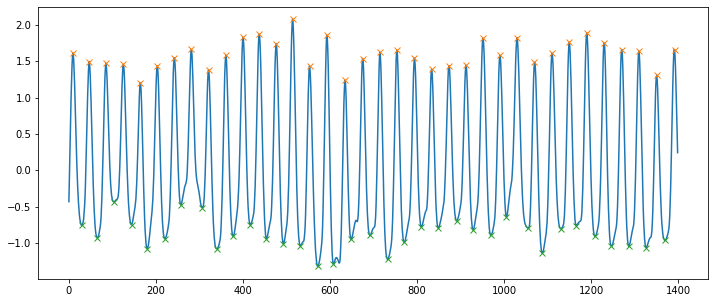

In [0]:
plt.figure(figsize=(12, 5))
plt.plot(norm_data)
plt.plot(norm_peaks, norm_data[norm_peaks], "x")
plt.plot(norm_valleys, norm_data[norm_valleys], "x")
plt.show()

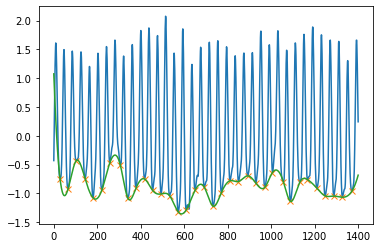

In [0]:
# Cubic Spline interpolation with selected valley points
base_drift = CubicSpline(norm_valleys, norm_data[norm_valleys])
xs = np.arange(norm_data.shape[0])
plt.plot(norm_data)
plt.plot(norm_valleys, norm_data[norm_valleys], "x")
plt.plot(xs, base_drift(xs), label="S''")
plt.show()

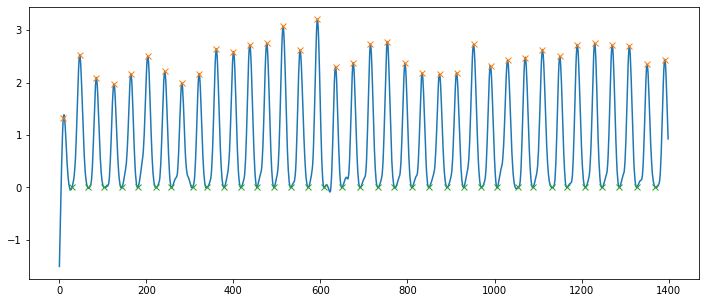

In [0]:
#remove baseline drift 
rm_rest_data = norm_data - base_drift(xs)


plt.figure(figsize=(12, 5))
plt.plot(rm_rest_data)
plt.plot(norm_peaks, rm_rest_data[norm_peaks], "x")
plt.plot(norm_valleys, rm_rest_data[norm_valleys], "x")

plt.show()

In [0]:
# listing the values code
valley_num = norm_valleys.shape[0]
signal_length = np.zeros(valley_num - 1)

for i in range(valley_num -1):
  
  signal_length[i] = norm_valleys[i+1] - norm_valleys[i]

  
# signal cycle들의 max value, length를 결정  
print('cycle num')
print(signal_length.shape[0])
signal_len = signal_length.shape[0]
avg_length = int(max(signal_length))

# listing the values code
valley_num = norm_valleys.shape[0]
signal_length = np.zeros(valley_num - 1)

for i in range(valley_num -1):
  
  signal_length[i] = norm_valleys[i+1] - norm_valleys[i]

  
# signal cycle들의 max value, length를 결정  
print('cycle num')
print(signal_length.shape[0])
signal_len = signal_length.shape[0]
avg_length = int(max(signal_length))
print('average length is determined by maximum of signal length ')
print(avg_length)
peak_max = max(rm_rest_data[norm_peaks])

cycle num
34
cycle num
34
average length is determined by maximum of signal length 
50


In [0]:
# cycle들을 interpolation을 위해 쪼개서 저장하기
cycles = [] # listing cycles
cycles_peaks = []
cycles_valleys = []

for i in range(0, signal_len - 1):
  cycles.append(rm_rest_data[norm_valleys[i]:norm_valleys[i+1]])
  cy_peaks, _ = find_peaks(cycles[i], distance=int(avg_length))
  cy_valleys, _ = find_peaks(-cycles[i], distance=int(avg_length))
  np.diff(cy_peaks)
  np.diff(cy_valleys)
  cycles_peaks.append(cy_peaks[0])
  cycles_valleys.append(cy_valleys)
  cycles[i] = np.pad(cycles[i], (0, avg_length - cycles[i].shape[0]))

In [0]:
# 쪼갠 cycle들을 이용하여 또다른 학습 dataset 만들기 -> 5개로 쪼개기
i = 0
cycle_num = signal_length.shape[0]
unit = int(cycle_num/5)
cycle_index = zip(range(0,cycle_num, unit), range(unit, cycle_num+1, unit))

crop_cycles = []
crop_cycles_peaks = []
crop_cycles_valleys = []

for start, end in cycle_index:
  if i == 4 : end = cycle_num 
  crop_cycles.append(cycles[start:end])
  crop_cycles_peaks.append(cycles_peaks[start:end])
  crop_cycles_valleys.append(cycles_valleys[start:end])
  if i == 4 : break

  i=i+1


iterations : 0
valley_Y : -0.11452100325462718
valley_X : 39


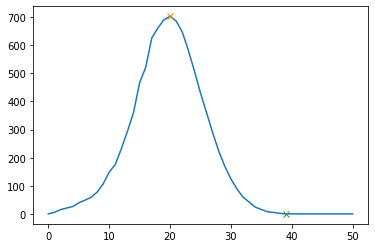

features
1. rotation angle
-1.5437957588620503
2. depth
-0.11452100325462718
3. curvature sum
0.7250400900686385
iterations : 1
valley_Y : 14.898220885580242
valley_X : 38


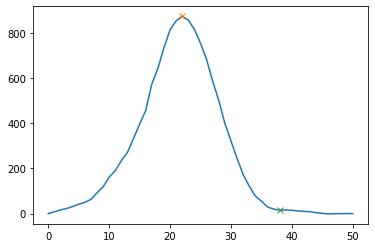

features
1. rotation angle
-1.5521834740465077
2. depth
-1.4885931834383785
3. curvature sum
2.6680609085525364
iterations : 2
valley_Y : -0.2126561690626255
valley_X : 46


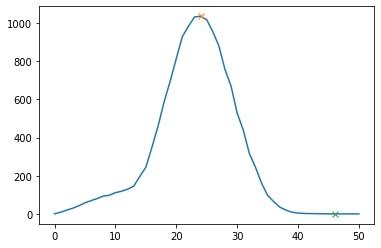

features
1. rotation angle
-1.5495723898600258
2. depth
-0.2126561690626255
3. curvature sum
1.9367241256877754
iterations : 3
valley_Y : -0.030379452723232215
valley_X : 46


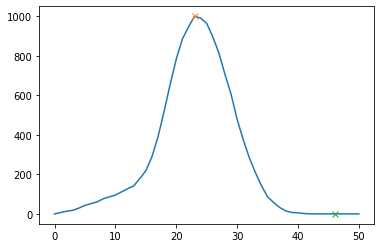

features
1. rotation angle
-1.5478294420085614
2. depth
-0.030379452723232215
3. curvature sum
0.6514488488621063
iterations : 4
valley_Y : -0.8821040594996351
valley_X : 47


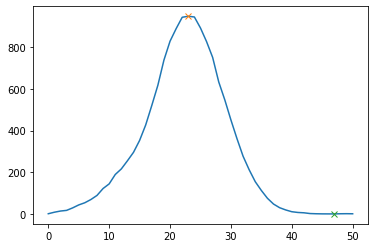

features
1. rotation angle
-1.545572140746865
2. depth
-0.8821040594996351
3. curvature sum
3.9282118904794494
[[array([-1.54379576, -0.114521  ,  0.72504009])], [array([-1.55218347, -1.48859318,  2.66806091])], [array([-1.54957239, -0.21265617,  1.93672413])], [array([-1.54782944, -0.03037945,  0.65144885])], [array([-1.54557214, -0.88210406,  3.92821189])]]
['normal', 'normal', 'normal', 'normal', 'normal']


In [0]:
# find average value of cardiac cycles (average cycle = cycle들의 합 / cycle 갯수로 구하기)
train_X = []
train_y = []
avg_data = np.zeros(avg_length)
for j in range(5):
  print('iterations : ' + str(j))
  cycles = cycles[j]
  cycle_num = len(cycles)

  for i in range(cycle_num):
      avg_data = avg_data + cycles[i]


  avg_data = avg_data/cycle_num

  # one cycle _ average data 
  avg_peaks, _ = find_peaks(avg_data, distance=cycle_num)
  avg_valleys, _ = find_peaks(-avg_data, distance=cycle_num)
  np.diff(avg_peaks)
  np.diff(avg_valleys)
  
  if avg_valleys.shape[0] == 0:
    last_data = avg_data[avg_length-1]
    valley_Y = last_data
    ind = len(np.where(avg_data == last_data)[0])
    valley_X = np.where(avg_data == last_data)[0][ind-1]
    print('valley_Y : ' + str(valley_Y))
    print('valley_X : ' + str(valley_X))

  else:
    valley_X = avg_valleys[0]
    valley_Y = avg_data[avg_valleys[0]]
    print('valley_Y : ' + str(valley_Y))
    print('valley_X : ' + str(valley_X))

    

  peak_X = avg_peaks[0]
  peak_Y = avg_data[avg_peaks[0]]

  theta = np.arctan((peak_Y - valley_Y)/(peak_X - valley_X))

  plt.plot(avg_data)
  plt.plot(peak_X, peak_Y, "x")
  plt.plot(valley_X, valley_Y, "x")
  plt.show()

  # 찾은 average data로 feature 뽑기
  avg = avg_data 

  # get depth of the valley from the average cardiac cycles (minimum of avg)
  depth = min(avg)

  # get curvature of the depth
  avg_d1 = np.diff(avg)
  avg_d2 = np.diff(avg_d1)
  del_ind = len(avg_d1)-1
  avg_d1 = np.delete(avg_d1, del_ind)

  curvature = abs(avg_d2)/((1+avg_d1**2))**(3/2)
  sum_curve = np.sum(curvature)

  # feature : 1. rotation angle 2. depth 3. curvature of waveform af rotation in avg signal
  print('features')
  print('1. rotation angle')
  print(theta)
  print('2. depth')
  print(depth)
  print('3. curvature sum')
  print(sum_curve)

  train_X.append([np.array([theta, depth, sum_curve])]) # theta 결정하고 나면 꼭 추가할것 data_sub(row) X feature num(column) 
  train_y.append('normal')

print(train_X)
print(train_y)

In [0]:
cwd = os.getcwd()
# feature save
np.save(cwd + '/feature_data/feature_crop_A10_JW', train_X)

# label save
np.save(cwd + '/feature_data/label_crop_A10_JW', train_y)
# f = open(cwd + '/feature_data/label_crop_JW.txt', 'w')
# f.write(train_y)
# f.close()

In [0]:
cwd = os.getcwd()
# make train vectors in features
train_X = [np.array([theta, depth, sum_curve])] # theta 결정하고 나면 꼭 추가할것 data_sub(row) X feature num(column) 
train_y = ['A10']

# feature save
np.save(cwd + '/feature_data/feature_crop_JW', train_X)

# label save
f = open(cwd + '/feature_data/label_crop_JW.txt', 'w')
f.write(train_y[0])
f.close()

#**model**

In [0]:
del train_X, train_y
train_X = []
train_y = []

In [0]:
array1 = np.load(cwd + '/feature_data/feature_crop_A10_JW.npy', allow_pickle=True)
for i in range(5):
  train_X.append(array1[i][0])

train_y = ['A10', 'A10', 'A10', 'A10', 'A10']
print(train_X)
print(train_y)

[array([-1.54379576, -0.114521  ,  0.72504009]), array([-1.55218347, -1.48859318,  2.66806091]), array([-1.54957239, -0.21265617,  1.93672413]), array([-1.54782944, -0.03037945,  0.65144885]), array([-1.54557214, -0.88210406,  3.92821189])]
['A10', 'A10', 'A10', 'A10', 'A10']


In [0]:
array1 = np.load(cwd + '/feature_data/feature_crop_A5_JW.npy', allow_pickle=True)
for i in range(5):
  train_X.append(array1[i][0])
  train_y.append('A5')

print(train_X)
print(train_y)

[array([-1.54379576, -0.114521  ,  0.72504009]), array([-1.55218347, -1.48859318,  2.66806091]), array([-1.54957239, -0.21265617,  1.93672413]), array([-1.54782944, -0.03037945,  0.65144885]), array([-1.54557214, -0.88210406,  3.92821189]), array([-1.54236956,  0.        , 16.44697969]), array([-1.54775464,  0.        ,  7.47685326]), array([-1.54793895,  0.        ,  6.26370221]), array([-1.54614363,  0.        ,  6.9621847 ]), array([-1.54502157,  0.        ,  2.33491427])]
['A10', 'A10', 'A10', 'A10', 'A10', 'A5', 'A5', 'A5', 'A5', 'A5']


In [0]:
array1 = np.load(cwd + '/feature_data/feature_crop_JW.npy', allow_pickle=True)
for i in range(5):
  train_X.append(array1[i][0])
  train_y.append('normal')

print(train_X)
print(train_y)

[array([-1.54379576, -0.114521  ,  0.72504009]), array([-1.55218347, -1.48859318,  2.66806091]), array([-1.54957239, -0.21265617,  1.93672413]), array([-1.54782944, -0.03037945,  0.65144885]), array([-1.54557214, -0.88210406,  3.92821189]), array([-1.54236956,  0.        , 16.44697969]), array([-1.54775464,  0.        ,  7.47685326]), array([-1.54793895,  0.        ,  6.26370221]), array([-1.54614363,  0.        ,  6.9621847 ]), array([-1.54502157,  0.        ,  2.33491427]), array([-1.48582053,  0.        ,  4.71677595]), array([-1.50309302,  0.        ,  2.13484412]), array([-1.50787372,  0.        ,  1.7042664 ]), array([-1.50619272,  0.        ,  5.78670355]), array([-1.48458675,  0.        ,  3.51438365])]
['A10', 'A10', 'A10', 'A10', 'A10', 'A5', 'A5', 'A5', 'A5', 'A5', 'normal', 'normal', 'normal', 'normal', 'normal']


In [0]:
array1 = np.load(cwd + '/feature_data/feature_set_JW_train.npy', allow_pickle=True)
print(array1)

[[array([-1.4571142]) 0.0 8.1558144314052]
 [-1.5089717093959838 0.0 7.2861873096746175]
 [array([-1.48258209]) -0.05487809511446863 2.7518571703937975]]


In [0]:
# if you want to use saved model, load_mode = True
load_mode = False

# encoded_train_X : (data_num * feature_num) / train_y : 1-D label

# load
if load_mode:
  with open(cwd + '/train_data/train_data_JW2.pickle', 'rb') as f:
    data = pickle.load(f)
else:
  svm = SVC(C=1, kernel='rbf',gamma='scale')
  svm.fit(train_X, train_y)


# save
with open(cwd + '/train_data/train_data_JW2.pickle', 'wb') as f:
    pickle.dump(svm, f, pickle.HIGHEST_PROTOCOL)


    # predict SVM
    svm_pred = svm.predict(test_X)
    svm_true = test_y
    accuracy = accuracy_score(svm_true, svm_pred)
    print(accuracy)

1.0


In [0]:
cwd = os.getcwd()
# make train vectors in features (load data)
ind = 0
# name_list = ['feature_JW_norm', 'feature_JW_A5', 'feature_JW_A10']
# label_list = ['label_JW_norm', 'label_JW_A5', 'label_JW_A10']

# name_list = ['feature_MJ_norm', 'feature_MJ_A5', 'feature_MJ_A10']
# label_list = ['label_MJ_norm', 'label_MJ_A5', 'label_MJ_A10']

name_list = ['feature_DAN_norm', 'feature_DAN_A5', 'feature_DAN_A10']
label_list = ['label_DAN_norm', 'label_DAN_A5', 'label_DAN_A10']

lines=[]


for ind in range(len(name_list)):
  # load feature
  array1 = np.load(cwd + '/feature_data/' + name_list[ind] + '.npy', allow_pickle=True)
  #array2 = np.load(cwd + '/feature_data/' + name_test[ind] + '.npy', allow_pickle=True)
  # load label
  f = open(cwd + '/feature_data/' + label_list[ind] +'.txt', 'r')
  lines.append(f.readline())

  ############ ++add++ ############
  train_X.append(array1[0])
  train_y.append(lines[0])



In [0]:
train_X[1][0] = train_X[1][0][0]

In [0]:
print(test_X)
print(test_y)

[array([array([-1.47893476]), 0.0, 1.7185430562326345], dtype=object), array([array([-1.49515232]), -0.009813122956050588, 5.40616830654579],
      dtype=object), array([-1.53799586,  0.        ,  3.40253582])]
['normal', 'A5', 'A10']


In [0]:
del test_y
test_y = ['A10', 'A5', 'normal']

In [0]:
test_X = []
test_y = []

test_name1 = ['feature_JW_test', 'feature_A5_JW_test', 'feature_A10_JW_test']
# label_name1 = ['label_JW_test', 'label_A5_JW_test', 'label_A10_JW_test']
# test_name2 = ['feature_MJ_test', 'feature_A5_MJ_test', 'feature_A10_MJ_test']
# label_name2 = ['label_MJ_test', 'label_A5_MJ_test', 'label_A10_MJ_test']
# test_name3 = ['feature_DAN_test', 'feature_A5_DAN_test', 'feature_A10_DAN_test']
# label_name3 = ['label_DAN_test', 'label_A5_DAN_test', 'label_A10_DAN_test']

for ind in range(len(test_name1)):
  # load feature
  array1 = np.load(cwd + '/feature_data/' + test_name1[ind] + '.npy', allow_pickle=True)
  #array2 = np.load(cwd + '/feature_data/' + name_test[ind] + '.npy', allow_pickle=True)
  # load label
  # f = open(cwd + '/feature_data/' + label_name1[ind] +'.txt', 'r')
  # lines.append(f.readline())

  ############ ++add++ ############
  test_X.append(array1[0])
  # test_y.append(lines[0])

print(test_X)
print(test_y)

[array([array([-1.47893476]), 0.0, 1.7185430562326345], dtype=object), array([array([-1.49515232]), -0.009813122956050588, 5.40616830654579],
      dtype=object), array([-1.53799586,  0.        ,  3.40253582])]
[]


In [0]:
del test_y
test_y = ['normal', 'A5', 'A10']

In [0]:
print(test_X)
print(test_y)

[array([array([-1.47893476]), 0.0, 1.7185430562326345], dtype=object), array([array([-1.49809721]), 0.0, 3.3803701323908624], dtype=object), array([array([-1.50382212]), 0.0, 0.5636765085017589], dtype=object)]
['normal', 'A5', 'A10']


In [0]:
# feature save
np.save(cwd + '/feature_data/feature_set_DAN_train', train_X)
np.save(cwd + '/feature_data/feature_set_DAN_test', test_X)

# label save
f = open(cwd + '/feature_data/label_set_DAN_train.txt', 'w')
f.write(str(train_y))
f.close()

f = open(cwd + '/feature_data/label_set_DAN_test.txt', 'w')
f.write(str(test_y))
f.close()

In [0]:
# if you want to use saved model, load_mode = True
load_mode = False

# encoded_train_X : (data_num * feature_num) / train_y : 1-D label

# load
if load_mode:
  with open(cwd + '/train_data/train_data_DAN.pickle', 'rb') as f:
    data = pickle.load(f)
else:
  svm = SVC(C=20, kernel='rbf',gamma='scale')
  svm.fit(train_X, train_y)


# save
with open(cwd + '/train_data/train_data_DAN.pickle', 'wb') as f:
    pickle.dump(svm, f, pickle.HIGHEST_PROTOCOL)


    # predict SVM
    svm_pred = svm.predict(test_X)
    svm_true = test_y
    accuracy = accuracy_score(svm_true, svm_pred)
    print(accuracy)

0.3333333333333333


In [0]:
svm_JW = SVC(C=20, kernel='rbf',gamma='scale')
svm_JW.fit([train_X[0], train_X[4]], [train_y[0], train_y[4]])

svm_pred = svm_JW.predict([test_X[1]])
svm_true = [test_y[1]]
accuracy = accuracy_score(svm_true, svm_pred)
print(accuracy)